### MNIST dataset CNN example with synapgrad

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

# Import .././ directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from synapgrad.utils.data import split_dataset, DataLoader, DataLoaderCallback
from synapgrad.utils.train import Trainer, Evaluator

In [3]:
supported_engines = ['synapgrad', 'torch']

In [4]:
seed = 1337
engine_str = 'synapgrad'

In [5]:
epochs = 5
batch_size = 128
lr = 0.01

In [6]:
if engine_str == 'synapgrad':
    import synapgrad as engine
    from synapgrad import nn
    from synapgrad import optim
elif engine_str == 'torch':
    import torch as engine
    from torch import nn
    from torch import optim
engine.manual_seed(seed)
print("Engine:", engine_str)

Engine: synapgrad


Load dataset

In [7]:
(trainX, trainy), (testX, testy) = mnist.load_data()
(trainX, trainy), (valX, valy), _  = split_dataset(trainX, trainy, test_split=0.2)

trainX = np.expand_dims(trainX / 255.0, axis=1)
valX = np.expand_dims(valX / 255.0, axis=1)
testX = np.expand_dims(testX / 255.0, axis=1)

assert 0 <= np.max(trainX) <= 1

# summarize loaded dataset
print("Sample shape:", trainX[0].shape)
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Val: X=%s, y=%s' % (valX.shape, valy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Sample shape: (1, 28, 28)
Train: X=(48000, 1, 28, 28), y=(48000,)
Val: X=(12000, 1, 28, 28), y=(12000,)
Test: X=(10000, 1, 28, 28), y=(10000,)


In [8]:
class Transform(DataLoaderCallback):
    
    def __call__(self, data_loader:'DataLoader', X_batch:np.ndarray, y_batch:np.ndarray):
        if engine_str == 'torch':
            x = engine.tensor(X_batch).type(engine.FloatTensor)
            y = engine.tensor(y_batch).type(engine.LongTensor)
        elif engine_str == 'synapgrad':
            x = engine.tensor(X_batch)
            y = engine.tensor(y_batch, dtype=np.int8)
        return x, y

transform_cb = Transform()

train_loader = DataLoader(trainX, trainy, batch_size, engine=engine, transform=transform_cb)
val_loader = DataLoader(valX, valy, batch_size=256, engine=engine, transform=transform_cb) # big batch size for val samples
test_loader = DataLoader(testX, testy, batch_size=256, engine=engine, transform=transform_cb) # big batch size for val samples

print("Batch sample shape:", train_loader[0][0].shape)
print("Train batches:", len(train_loader), "| Val batches:", len(val_loader), "| Test batches:", len(test_loader))

Batch sample shape: (128, 1, 28, 28)
Train batches: 375 | Val batches: 46 | Test batches: 39


Plot a few training images

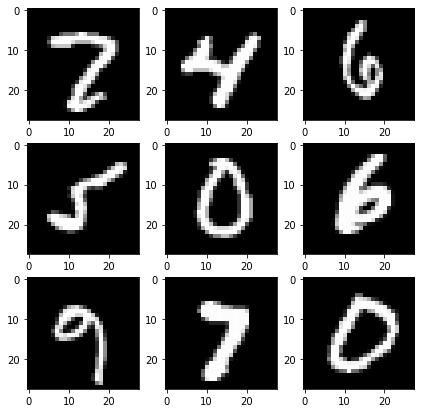

In [9]:
plt.figure(figsize=(7,7))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i].squeeze(), cmap=plt.get_cmap('gray'))
plt.show()

In [10]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(1, 16, (3,3), (1,1), padding='same'),  
            nn.BatchNorm2d(16),                         
            nn.ReLU(),
            nn.Dropout(0.3),                    
            nn.MaxPool2d(kernel_size=(2,2))
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, (3,3), (1,1), padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),     
            nn.Dropout(0.3),                 
            nn.MaxPool2d(kernel_size=(2,2))
        )
        self.flatten = nn.Flatten()
        self.out = nn.Linear(32 * 7 * 7, 10)
        
        self.cnn = nn.Sequential(
            self.conv1, self.conv2, self.flatten, self.out
        )
        
        if engine_str == 'synapgrad': self.track_module(self.cnn)
        
    def forward(self, x:engine.Tensor):
        out = self.cnn(x)
        
        return out

model = CNN()
print("CNN Model:", model)
print("CNN Trainable Parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

CNN Model: CNN(tracked_modules=1, parameters=20586, trainable=20586, non_trainable=0)
CNN Trainable Parameters: 20586


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

trainer = Trainer(model, engine)
evaluator = Evaluator(accuracy=True, mode=Evaluator.MULTI_CLASS)
trainer.compile(loss_fn, optimizer, evaluator)
history = trainer.fit(train_loader, epochs=epochs, validation_loader=val_loader)

Epoch: 1/5
375/375 [================================] - 351s 935ms/step - loss: 0.9264 - accuracy: 0.8864 - val_loss: 0.1468 - val_accuracy: 0.9570
Epoch: 2/5
375/375 [================================] - 334s 891ms/step - loss: 0.1812 - accuracy: 0.9534 - val_loss: 0.1036 - val_accuracy: 0.9697
Epoch: 3/5
375/375 [================================] - 331s 884ms/step - loss: 0.1135 - accuracy: 0.9658 - val_loss: 0.0948 - val_accuracy: 0.9738
Epoch: 4/5
375/375 [================================] - 328s 875ms/step - loss: 0.0912 - accuracy: 0.9711 - val_loss: 0.0880 - val_accuracy: 0.9763
Epoch: 5/5
375/375 [================================] - 335s 894ms/step - loss: 0.0779 - accuracy: 0.9755 - val_loss: 0.0791 - val_accuracy: 0.9792


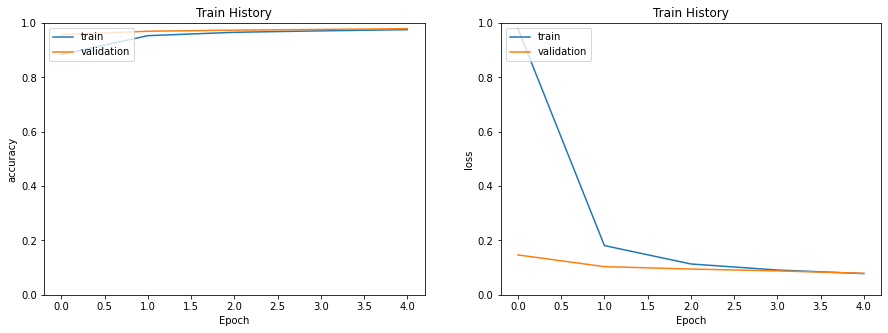

In [12]:
trainer.plot(['accuracy', 'loss'], ylim=[0, 1])

In [13]:
y_pred, y_true = trainer.test(test_loader)
evaluator.report(y_pred, y_true)

[INFO] Testing network...
Accuracy: 0.9809695512820513
[[ 975    0    1    0    0    0    2    1    0    0]
 [   0 1132    1    0    0    0    0    0    0    0]
 [   4    3 1006    7    3    1    0    5    1    0]
 [   2    0    0  987    0   13    0    5    1    0]
 [   0    1    0    0  968    0    1    1    1    8]
 [   1    1    1    2    0  884    1    0    0    0]
 [  11    7    0    1    2    6  929    0    0    0]
 [   2    4    6    1    0    0    0 1012    1    1]
 [  12    2    3    3    2    4    3    6  934    4]
 [   5    8    0    1    9   10    1    7    0  967]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       979
           1       0.98      1.00      0.99      1133
           2       0.99      0.98      0.98      1030
           3       0.99      0.98      0.98      1008
           4       0.98      0.99      0.99       980
           5       0.96      0.99      0.98       890
           6       0.99      0.97  

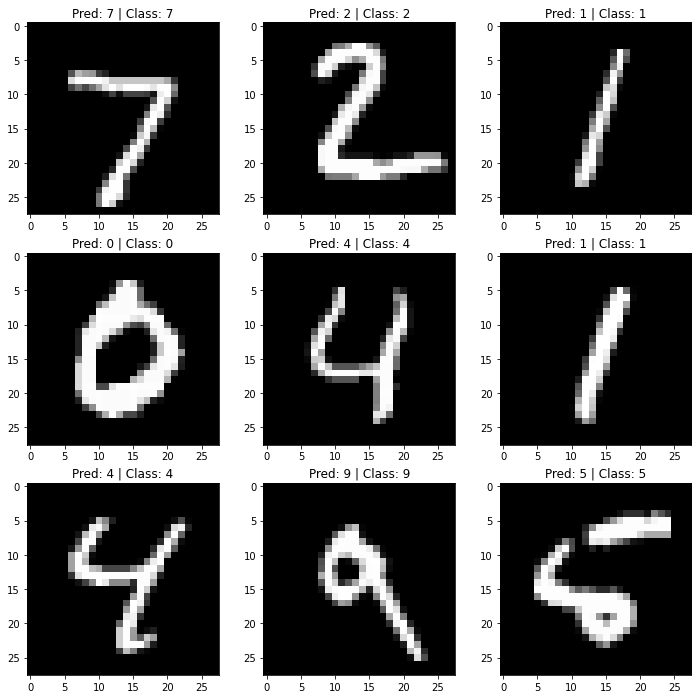

In [14]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(testX[i].squeeze(), cmap=plt.get_cmap('gray'))
    pred = y_pred[i].argmax(); label = y_true[i]
    plt.title(f"Pred: {pred} | Class: {label}")
plt.show()